I want to get closer to a more meaningful answer of targeting vs delivery. 

Right now we’re showing that clickbait is targeted more to older users and it is delivered more to older users; at the same time the audiences are huge so the platform retains a lot of power to optimize delivery. 

Still, we don’t actually provide statistical “proof” that delivery optimization skews the results further than just the targeting. 

One possible ways to get closer would be to only include ads with default targeting in the analysis:
* use single ads as the unit of analysis (instead of a user), 
* demographics of its recipient as the independent variables, 
* ad category as independent variable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
%matplotlib inline

plt.rcParams['font.family'] = 'serif'
plt.rcParams["font.serif"] = ["Nimbus Roman"]

In [2]:
import os
!pwd

/home/ali/pred-ads/analyses/rq3


In [3]:
codes_file = '../data/ad_codes_transformed.tsv'
codes = pd.read_csv(codes_file, sep='\t')
adid_codes = dict(zip(codes['adid'], [r.split(';') for r in codes['codes']]))

In [4]:
targeting_params = pd.read_csv('/home/piotr/targeting_params.csv', low_memory=False)

In [5]:
# get rid of the Nigerian and Indian ads
targeting_params = targeting_params.loc[targeting_params['location'] != "{'serialized': {'location_granularity': 'country', 'location_geo_type': 'home', 'location_code': 'NG'}, 'location_name': 'Nigeria', 'location_type': 'HOME'}"]
targeting_params = targeting_params.loc[targeting_params['location'] != "{'serialized': {'location_granularity': 'country', 'location_geo_type': 'home', 'location_code': 'IN'}, 'location_name': 'India', 'location_type': 'HOME'}"]

In [6]:
maus = {row['adid']: row['estimate_mau'] for idx, row in targeting_params.iterrows()}

In [7]:
data = []
for adid, adcodes in adid_codes.items():
    row = {code: 1 for code in adcodes}
    row['adid'] = adid
    try:
        row['estimate_mau'] = maus[adid]
    except:
        row['estimate_mau'] = float('nan')
    data.append(row)
        

In [8]:
data = pd.DataFrame(data)

In [9]:
# def ecdf(a):
#     x, counts = np.unique(a, return_counts=True)
#     cusum = np.cumsum(counts)
#     return x, cusum / cusum[-1]

# for column in data.columns[:9]:
#     if column == 'estimate_mau':
#         continue
#     a = np.sort(data.loc[(data[column]==1) & (data['estimate_mau'] >= 0), 'estimate_mau'])
#     x, y = ecdf(a)
    
#     plt.plot(x, y, label=column)
# plt.legend()

# plt.ylabel('fraction of ads')
# plt.xlabel('targeted audience size')
# #plt.xscale('log')
# plt.xlim(1e3, 0.3e8)
#     #plt.title(column)
#     #plt.show()

In [10]:
# now let's find out what interests are the most popular in each category

In [11]:
import json
interests = json.loads(open('/home/piotr/interest_lookup.json').read())

In [12]:
from collections import defaultdict
use_counts = defaultdict(lambda: defaultdict(int))
import ast

totals = {code: data[code].sum() for code in data.columns}

for idx, row in targeting_params.iterrows():
    try:
        codes = adid_codes[row['adid']]
    except:
        continue
        
    if row['WAISTUIInterestsType'] is not None and type(row['WAISTUIInterestsType'])==str:
        for interest_id in ast.literal_eval(row['WAISTUIInterestsType'])['interest_ids']:
            for code in codes:
                try:
                    use_counts[code][interests[str(interest_id)]] += 1/totals[code]
                except:
                    continue
    else:
        for code in codes:
            use_counts[code]['None'] += 1/totals[code]
    

In [13]:
parameters = ['age_min', 'age_max','gender', 'location', 'WAISTUILocaleType', 'WAISTUIInterestsType', 'WAISTUICustomAudienceType', 'default']

In [14]:
use_counts.keys()

dict_keys(['Benign', 'Opportunity', 'Healthcare', 'Clickbait', 'Financial', 'Sensitive', 'Potentially Prohibited', 'Potentially Harmful'])

In [15]:
from operator import itemgetter
for code in use_counts:
    items = sorted(use_counts[code].items(), key=itemgetter(1), reverse=True)
    print(code)
    print(items[:20])
    print()

Benign
[('None', 0.6889961484080827), ('Online shopping', 0.011749792794110486), ('Health & wellness', 0.007508166349763547), ('Family', 0.00633806250304715), ('Yoga', 0.006143045195261084), ('Dogs', 0.006045536541368051), ('Physical fitness', 0.005704256252742435), ('Physical exercise', 0.005606747598849402), ('Coupons', 0.005021695675491203), ('Entertainment', 0.004972941348544687), ('Shopping and fashion', 0.004972941348544687), ('Pets', 0.00492418702159817), ('Amazon.com', 0.004826678367705137), ('Cats', 0.004729169713812104), ('Walmart', 0.004290380771293455), ('Cooking', 0.004192872117400422), ('Shopping', 0.004192872117400422), ('Travel', 0.003997854809614356), ('Running', 0.003997854809614356), ('Video games', 0.003900346155721323)]

Opportunity
[('None', 0.5954269715352308), ('Employment', 0.024731684554363035), ('Education', 0.02239850676621558), ('Higher education', 0.021465235650956597), ('Career', 0.01539897340177321), ('Technology', 0.014465702286514228), ('Psychology', 0

In [16]:
use_counts['code'].items()

dict_items([])

In [17]:
# Usage of different targeting _types_ per ad category

from tqdm import tqdm


In [32]:
params_df = targeting_params.set_index('adid')
categories = ['Benign', 'Healthcare', 'Opportunity', 'Sensitive', 'Financial', 'Clickbait', 'Potentially Harmful',  'Potentially Prohibited', 
              ]

In [19]:
usage_counter = defaultdict(lambda: defaultdict(int))
any_counter = defaultdict(int)
fails = 0
for idx, row in (tqdm(data.iterrows())):
    try:
        params = params_df.loc[data['adid'][idx]]
        used = []
        for k in params.keys():
            if k in ['adid', 'estimate_mau']: continue
            if not pd.isna(params[k]):
                used.append(k)
        if used == []:
            used = ['default']
            
        for category in row.keys():
            if category in ['adid', 'estimate_mau']: continue
            
            if not pd.isna(row[category]):
                any_counter[category] += 1
                for param in used:
                    usage_counter[category][param] += 1
    except:
        fails += 1
    
    
    

29207it [00:16, 1726.11it/s]


In [20]:
fails

1705

In [30]:
new_categogories = {
    'Benign': 'Neutral',
    'Opportunity': 'Opportunity',
    'Healthcare': 'Healthcare',
    'Potentially Prohibited': 'Pot. Prohibited',
    'Potentially Harmful': 'Deceptive',
    'Financial': 'Sensitive: Financial',
    'Sensitive': 'Sensitive: Other',
    'Clickbait': 'Clickbait'
}

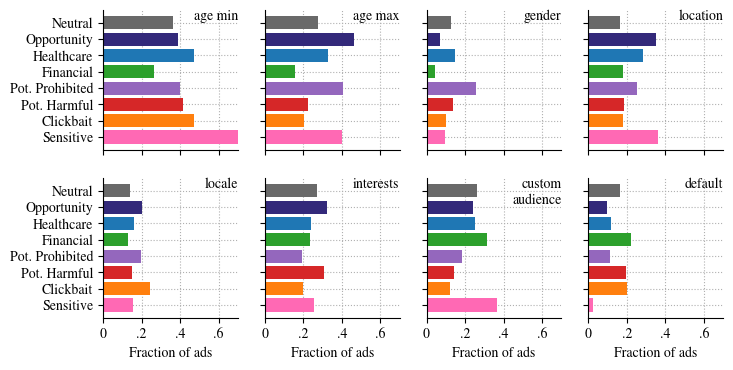

In [22]:
colors = {'Financial': 'tab:green', 'Problematic (all together)': 'maroon', 
          'Benign': 'dimgray', 'Potentially Harmful': 'tab:red', 
          'Clickbait': 'tab:orange', 'Potentially Prohibited': 
          'tab:purple', 'Sensitive': 'hotpink',
          'Healthcare': 'tab:blue', 'Opportunity': '#33297a'}

categories = ['Benign', 'Opportunity', 'Healthcare', 'Financial', 'Potentially Prohibited', 
              'Potentially Harmful', 'Clickbait', 'Sensitive']
f, axes = plt.subplots(2, 4, sharey = True, sharex = True)
for pidx, parameter in enumerate(parameters):
    ax = axes[pidx//4, pidx%4]
    for cidx, category in enumerate(categories[::-1]):
        try:
            frac = usage_counter[category][parameter] / any_counter[category]
        except:
            frac = 0
        ax.barh(cidx, frac, color = colors[category])
    ax.annotate(text=parameter.replace('WAISTUI', '')\
                .replace('Type', '')\
                .replace('_', ' ')\
                .replace('CustomAudience', 'custom\naudience')\
                .lower(), 
               xy=(1, 1), xycoords='axes fraction', ha = 'right', va='top')
    
    if pidx//4 == 1:
        ax.set_xlabel('Fraction of ads')
    if pidx%4 == 0:
        ax.set_yticks(range(0, len(categories)))
        ax.set_yticklabels([c.replace('Potentially', 'Pot.').replace('Benign', 'Neutral') for c in categories[::-1]])
        
    ax.set_xticks([0, .2, .4, .6,])
    ax.set_xticklabels(['0', '.2', '.4', '.6',])
    ax.set_xlim(0, .7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls=':')
    ax.set_axisbelow(True)
f.set_size_inches(8, 4)
f.savefig('rq3_prevalence.pdf', bbox_inches='tight')

In [23]:
combined = targeting_params.set_index('adid').join(data.set_index('adid'), how='inner', lsuffix='l')

In [24]:


combined['age_min_explicit'] = combined['age_min'].map(lambda x: 6 if pd.isna(x) else x)
combined['age_max_explicit'] = combined['age_max'].map(lambda x: 54 if pd.isna(x) else x)

In [34]:
fractions = []
for idx, category in enumerate(categories[::-1]):
    cat_total = (~combined[category].isna()).sum()
    cat_fractions = []
    
    cat_idx = ~combined[category].isna()
    for age in range(18, 66):
        age_idx = cat_idx & (combined['age_min_explicit'] <= age-12) & (combined['age_max_explicit'] > age-12)
        # if age >= 18:
        #     age_idx = age_idx | (cat_idx & combined['age_min'].isna())
        cat_fractions.append(age_idx.sum()/cat_idx.sum())
    fractions.append(cat_fractions)
   

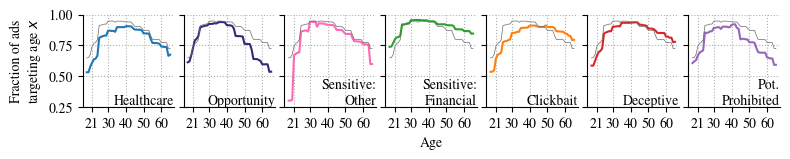

In [212]:
f, axes = plt.subplots(1, 7, sharey=True, sharex=True)
                       
for lidx, (line, category) in enumerate(zip(fractions[::-1][1:], categories[1:])):
    axes[lidx].plot(range(18, 66), line, label=category, color = colors[category])
    axes[lidx].plot(range(18, 66), fractions[-1], label=category, color = colors['Benign'], lw=0.5)
                          
    axes[lidx].spines['top'].set_visible(False)
    axes[lidx].spines['right'].set_visible(False)
    axes[lidx].grid(ls=':')
    axes[lidx].set_axisbelow(True)
    if lidx==3: axes[lidx].set_xlabel('Age')
    axes[lidx].annotate(new_categogories[category].replace(' ', '\n'), xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom')
    
    
axes[1].set_ylim(0.25, 1)

axes[0].set_ylabel('Fraction of ads\ntargeting age $x$')
axes[0].set_xticks([21, 30, 40, 50, 60])
f.subplots_adjust(wspace=0.1)
f.set_size_inches(9, 1.2)
f.savefig('rq3_ages_oneline.pdf', bbox_inches='tight')

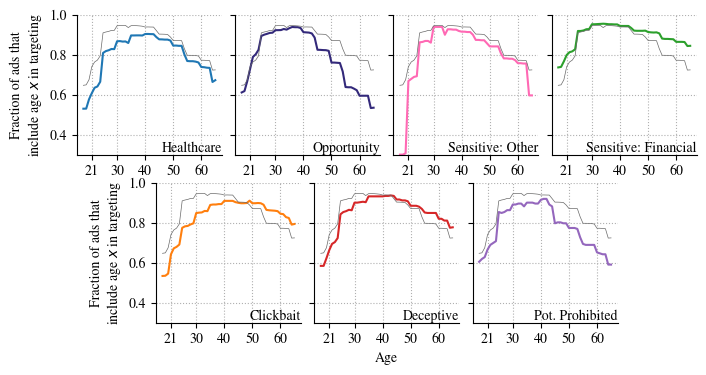

In [35]:
# Create 2x2 sub plots
import matplotlib.gridspec as gridspec


gs = gridspec.GridSpec(2, 8)
f = plt.figure()

#f, axes = plt.subplots(2, 4, sharey=True, sharex=True)
                       
for lidx, (line, category) in enumerate(zip(fractions[::-1][1:], categories[1:])):
    ax = f.add_subplot(gs[lidx//4, (((lidx%4)*2+lidx//4)) : (((lidx%4)*2+2+lidx//4))])
    ax.plot(range(18, 66), line, label=category, color = colors[category])
    ax.plot(range(18, 66), fractions[-1], label=category, color = colors['Benign'], lw=0.5)
      
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls=':')
    ax.set_axisbelow(True)
    ax.set_ylim(0.3, 1)
    if lidx % 4 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Fraction of ads that\ninclude age $x$ in targeting')
    
    ax.set_xticks([21, 30, 40, 50, 60])
    
    
    if lidx == 5: 
        ax.set_xlabel('Age')
        
    ax.annotate(new_categogories[category], xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom')
    # axes[lidx//4][lidx%4].set_xlabel('Age')
    #axes[lidx//4][lidx%4].set_title(new_categogories[category])
    
    
#axes[0][1].set_ylim(0.25, 1)

# axes[0].set_ylabel('Probability\nof being targeted')
# axes[0].set_xticks([21, 30, 40, 50, 60])

f.set_size_inches(8, 4)
f.savefig('rq3_ages_y.pdf', bbox_inches='tight')

In [398]:
((lidx*2+lidx//4)%10)

3

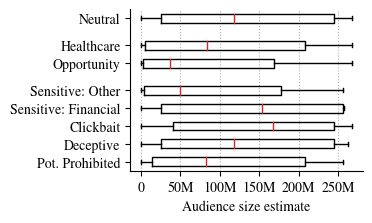

In [88]:
boxplot_data = []

offsets = np.array([0, .5, .5, 1, 1, 1, 1, 1])[::-1]


for idx, category in enumerate(categories[::-1]):
    # ax.barh(idx, data.loc[~data[category].isna(), 'estimate_mau'].median(), color=colors[category])
    boxplot_data.append(combined.loc[(~combined[category].isna()) & (~combined['estimate_mau'].isna()) & (combined['estimate_mau'] > 0), 'estimate_mau'])
    
f, ax = plt.subplots()
ax.boxplot(boxplot_data, vert=False, medianprops={'color':'tab:red'}, positions = (np.arange(1, len(boxplot_data)+1) - offsets))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(ls=':')
ax.set_axisbelow(True)
ax.set_yticks(np.arange(1, len(categories)+1)-offsets)
ax.set_yticklabels([new_categogories[c] for c in categories[::-1]])
ax.set_xlabel('Audience size estimate')
ax.set_xticks([0, .5e8, 1.00e8, 1.5e8, 2e8, 2.5e8])
ax.set_xticklabels(['0', '50M', '100M', '150M', '200M', '250M'])

f.set_size_inches(3, 2.1)
f.savefig('rq3_audience_size_b.pdf', bbox_inches='tight')

**Inspecting median sizes**

In [156]:
for i, c in enumerate(categories[::-1]):
    print(c, np.median(boxplot_data[i]))

Potentially Prohibited 82650000.0
Potentially Harmful 117900000.0
Clickbait 168200000.0
Financial 153950000.0
Sensitive 49950000.0
Opportunity 36800000.0
Healthcare 83400000.0
Benign 117900000.0


Potentially Prohibited 27 28 213
Potentially Harmful 24 38 446
Clickbait 24 70 935
Financial 34 16 1158
Sensitive 28 28 584
Opportunity 32 95 1888
Healthcare 103 310 2834
Benign 625 1846 19444


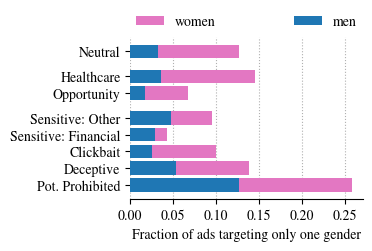

In [159]:
# gender
f, ax = plt.subplots()
for idx, category in enumerate(categories[::-1]):
    y = idx - offsets[idx]
    cidx = ~combined[category].isna()
    women_count = (cidx & (combined['gender'] == 1)).sum()
    men_count = (cidx & (combined['gender'] == 2)).sum()
    
    women = women_count/(cidx).sum()
    men = men_count/(cidx).sum()
    
    print(category, men_count, women_count, (cidx).sum())
    
    if idx == 0:
        ax.barh(y, men+women, color='tab:pink', label='women')
        ax.barh(y, men, color='tab:blue', label='men')
    else:
        ax.barh(y, men+women, color='tab:pink')
        ax.barh(y, men, color='tab:blue')
    #for aidx, (data, color) in enumerate(zip([-women, men], ['tab:pink', 'tab:blue'])):
        
        # axes[aidx].annotate(text=f'{int(round(abs(data)*100))}%'.replace('0.','.'), 
        #                     xy = (data, idx), va='center',
        #                     ha = 'left' if data < 0.03 else 'right',
        #                     color = 'k' if data < 0.03 else 'white')

    

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.grid(ls=':')
ax.set_axisbelow(True)

# ax.set_xticks([0.15, .1, .05, 0])
# ax.set_xticklabels(['0.15', '0.10', '0.05', '0'])

ax.set_xlabel('Fraction of ads targeting only one gender')

ax.set_xticks([0, 0.05, .1, .15, .2, .25])

ax.set_yticks(np.arange(0, len(categories)) - offsets)
ax.set_yticklabels([new_categogories[c] for c in categories[::-1]]) 

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0., frameon=False)

#f.subplots_adjust(wspace=0.1)
f.set_size_inches(3, 2.1)
# f.savefig('rq3_genders_onepanel.pdf', bbox_inches='tight')
# ax.set_xticks([-.1, -.05, 0, .05, .1])
# ax.set_xticklabels([.1, .05, 0, 0.05, .1])

In [167]:
# how many ads have any gender targeting?
use_gender = combined[~combined['gender'].isna()].shape[0]
total = combined.shape[0]
print(use_gender, total, round(use_gender/total * 100, 2))

3328 27502 12.1


In [256]:
# # Age targeting
# y, x = np.histogram(targeting_params['age_min'] + 12, bins=np.arange(0, 70, 1))
# plt.plot((x[1:]+x[:-1])/2, y/targeting_params.shape[0], label='min age')
# y, x = np.histogram(targeting_params['age_max'] + 12, bins=np.arange(0, 70, 1))
# plt.plot((x[1:]+x[:-1])/2, y/targeting_params.shape[0], label='max age')
# plt.legend()
# plt.xlabel('Age')
# plt.ylabel('Fraction of all ads')
# plt.grid()

In [254]:
# location granularity
import json
import ast
def get_granularity(val):
    try:
        return ast.literal_eval(val)['serialized']['location_granularity']
    except:
        return 'default'

location_granularity = targeting_params['location'].map(lambda x: get_granularity(x))

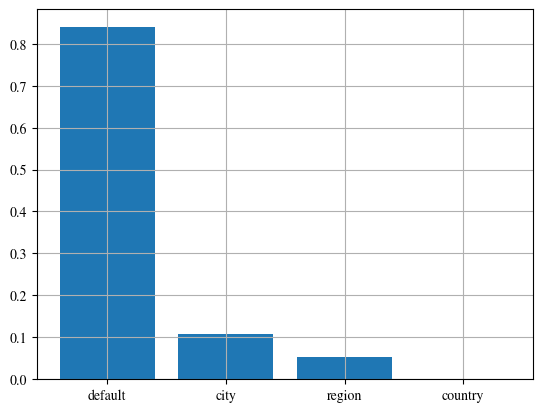

In [440]:
counts = Counter(location_granularity)
labels = []
for idx, item in enumerate(counts.most_common()):
    labels.append(item[0])
    plt.bar(idx, item[1]/targeting_params.shape[0], color='tab:blue')
    
plt.xticks(range(0, len(labels)), labels)
plt.grid()

In [40]:
# custon audience use
custom_audiences = pd.read_csv('/home/piotr/custom_types.csv')
custom_audiences.set_index('Unnamed: 0', inplace=True)
custom_audiences['CUSTOM_AUDIENCES_OTHER'] = custom_audiences['CUSTOM_AUDIENCES_MOBILE_APP'] == 1
del custom_audiences['CUSTOM_AUDIENCES_MOBILE_APP']
for k in ['CUSTOM_AUDIENCES_ENGAGEMENT_PAGE', 'CUSTOM_AUDIENCES_ENGAGEMENT_IG',
       'CUSTOM_AUDIENCES_ENGAGEMENT_VIDEO', 'CUSTOM_AUDIENCES_OFFLINE',
       'CUSTOM_AUDIENCES_ENGAGEMENT_LEAD_GEN',
       'CUSTOM_AUDIENCES_ENGAGEMENT_EVENT']:
    custom_audiences['CUSTOM_AUDIENCES_OTHER'] = custom_audiences['CUSTOM_AUDIENCES_OTHER'] | (custom_audiences[k] == 1)
    del custom_audiences[k]

In [41]:
values = defaultdict(float)
for column in custom_audiences.columns:
    val =  custom_audiences[column].sum()/targeting_params.shape[0]
    key = column.split('_')[-1]
    if key not in ['LOOKALIKE', 'DATAFILE', 'WEBSITE', 'OTHER']:
    #     key = 'OTHER'
    # values[key.lower()] += val
        continue
    values[key.lower()] += val
#values['any'] = custom_audiences.shape[0]/targeting_params.shape[0]

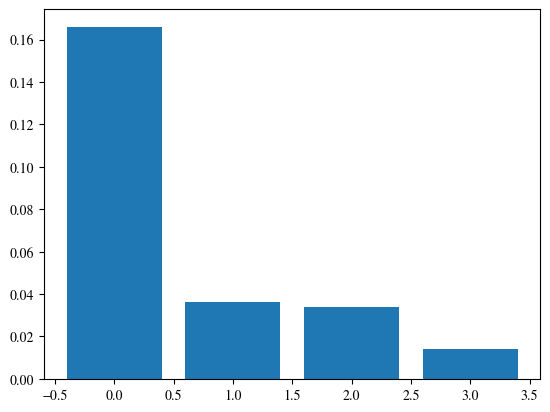

In [42]:
f, ax = plt.subplots()
for idx, (k, v) in enumerate(values.items()):
    ax.bar(idx, v, color='tab:blue')


In [43]:
joined = custom_audiences.join(combined, how='inner')

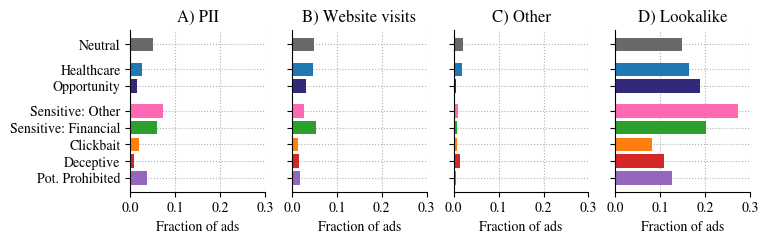

In [97]:
f, axes = plt.subplots(1, 4, sharey=True, sharex=False)

ca_labels = {'CUSTOM_AUDIENCES_LOOKALIKE': 'D) Lookalike', 
            'CUSTOM_AUDIENCES_DATAFILE': 'A) PII',
            'CUSTOM_AUDIENCES_WEBSITE': 'B) Website visits',
            'CUSTOM_AUDIENCES_OTHER': 'C) Other'}

for axidx, k in enumerate(['CUSTOM_AUDIENCES_DATAFILE', 	
                           'CUSTOM_AUDIENCES_WEBSITE', 
                           'CUSTOM_AUDIENCES_OTHER',
                          'CUSTOM_AUDIENCES_LOOKALIKE']):
    ax = axes[axidx]
    for cidx, category in enumerate(categories[::-1]):
        y = cidx - offsets[cidx]
        ax.barh(y, joined.loc[joined[category]==1, k].sum()/(combined[category] == 1).sum(), color=colors[category])

    # ax.set_xticks([0, .2, .4, .6,])
    # ax.set_xticklabels(['0', '.2', '.4', '.6',])
    # ax.set_xlim(0, .7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls=':')
    ax.set_axisbelow(True)
    ax.set_xlabel('Fraction of ads')
    ax.set_title(ca_labels[k])
    ax.set_xlim(0, 0.3)

axes[0].set_yticks(np.arange(0, len(categories))-offsets)
axes[0].set_yticklabels([new_categogories[c] for c in categories[::-1]])
    
f.set_size_inches(8, 2.1)
f.savefig('rq3_ca_prevalence.pdf', bbox_inches='tight')

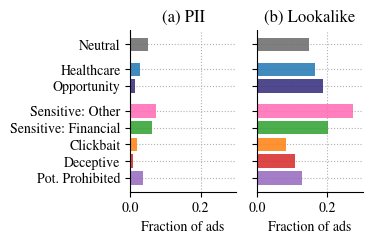

In [193]:
f, axes = plt.subplots(1, 2, sharey=True, sharex=False)

ca_labels = {'CUSTOM_AUDIENCES_LOOKALIKE': '(b) Lookalike', 
            'CUSTOM_AUDIENCES_DATAFILE': '(a) PII',
            'CUSTOM_AUDIENCES_WEBSITE': 'B) Website visits',
            'CUSTOM_AUDIENCES_OTHER': 'C) Other'}

for axidx, k in enumerate(['CUSTOM_AUDIENCES_DATAFILE', 	
                          'CUSTOM_AUDIENCES_LOOKALIKE']):
    ax = axes[axidx]
    for cidx, category in enumerate(categories[::-1]):
        y = cidx - offsets[cidx]
        ax.barh(y, joined.loc[joined[category]==1, k].sum()/(combined[category] == 1).sum(), color=colors[category],
               alpha=.85)

    # ax.set_xticks([0, .2, .4, .6,])
    # ax.set_xticklabels(['0', '.2', '.4', '.6',])
    # ax.set_xlim(0, .7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls=':')
    ax.set_axisbelow(True)
    ax.set_xlabel('Fraction of ads')
    ax.set_title(ca_labels[k])
    ax.set_xlim(0, 0.3)

axes[0].set_yticks(np.arange(0, len(categories))-offsets)
axes[0].set_yticklabels([new_categogories[c] for c in categories[::-1]])
    
f.set_size_inches(3, 2.1)
# f.savefig('rq3_ca_prevalence.pdf', bbox_inches='tight')

In [423]:
#demographics = ['age_min_explicit', 'age_max_explicit', 'gender', 'location']

usage_fractions = defaultdict(dict)



for cat in categories:
    total = ~combined[cat].isna()
    
    # demographics
    dem_use =  total & ((combined['age_min_explicit']!=6) |\
                    (combined['age_max_explicit']!=54) |\
                    (~combined['gender'].isna()) |\
                    (~combined['location'].isna()))
    
    

    usage_fractions['Demographics'][cat] = dem_use.sum()/total.sum()
    
    # interests
    interest_use = total & (~combined['WAISTUIInterestsType'].isna())
    usage_fractions['Interests'][cat] = interest_use.sum()/total.sum()
    
    # custom
    custom_use = total & (~combined['WAISTUICustomAudienceType'].isna())
    usage_fractions['Custom Audiences'][cat] = custom_use.sum()/total.sum()
    
    # default
    default_use = total & (combined['age_min_explicit']==6)\
                & (combined['age_max_explicit']==54)\
                & ((combined['WAISTUILocaleType'].isin(["{'locales': [24, 6]}","{'locales': [6]}"])) \
                       | combined['WAISTUILocaleType'].isna())
    for param in ['WAISTUIInterestsType', 'WAISTUILocaleType', 'WAISTUICustomAudienceType',
                 'WAISTUIBCTType', 'WAISTUIEduStatusType', 'WAISTUIDPAType',
           'WAISTUIActionableInsightsType', 'WAISTUIFriendsOfConnectionType',
           'WAISTUIRelationshipType', 'WAISTUIWorkEmployerType',
           'WAISTUILocalReachType', 'WAISTUIEduSchoolsType',
           'WAISTUIConnectionType', 'WAISTUICollaborativeAdsStoreVisitsType',
           'WAISTUIJobTitleType']:
        default_use = default_use & combined[param].isna()
    usage_fractions['Default'][cat] = default_use.sum()/total.sum()
                
    

    

In [77]:
#demographics = ['age_min_explicit', 'age_max_explicit', 'gender', 'location']

usage_fractions = defaultdict(dict)



for cat in categories:
    total = ~combined[cat].isna()
    
    # demographics
    dem_use =  total & ((combined['age_min_explicit']!=6) |\
                    (combined['age_max_explicit']!=54) |\
                    (~combined['gender'].isna())                    )
    
    

    usage_fractions['Age and gender'][cat] = dem_use.sum()/total.sum()
    
    # location
    usage_fractions['Location'][cat] = (total & (~combined['location'].isna())).sum()/total.sum()
    
    # interests
    interest_use = total & (~combined['WAISTUIInterestsType'].isna())
    usage_fractions['Interests'][cat] = interest_use.sum()/total.sum()
    
    # custom
    custom_use = total & (~combined['WAISTUICustomAudienceType'].isna())
    usage_fractions['Custom Audiences'][cat] = custom_use.sum()/total.sum()
    
    # default
    default_use = total & (combined['age_min_explicit']==6)\
                & (combined['age_max_explicit']==54)\
                & ((combined['WAISTUILocaleType'].isin(["{'locales': [24, 6]}","{'locales': [6]}"])) \
                       | combined['WAISTUILocaleType'].isna())
    for param in ['WAISTUIInterestsType', 'WAISTUILocaleType', 'WAISTUICustomAudienceType',
                 'WAISTUIBCTType', 'WAISTUIEduStatusType', 'WAISTUIDPAType',
           'WAISTUIActionableInsightsType', 'WAISTUIFriendsOfConnectionType',
           'WAISTUIRelationshipType', 'WAISTUIWorkEmployerType',
           'WAISTUILocalReachType', 'WAISTUIEduSchoolsType',
           'WAISTUIConnectionType', 'WAISTUICollaborativeAdsStoreVisitsType',
           'WAISTUIJobTitleType']:
        default_use = default_use & combined[param].isna()
    usage_fractions['Default'][cat] = default_use.sum()/total.sum()
                
    


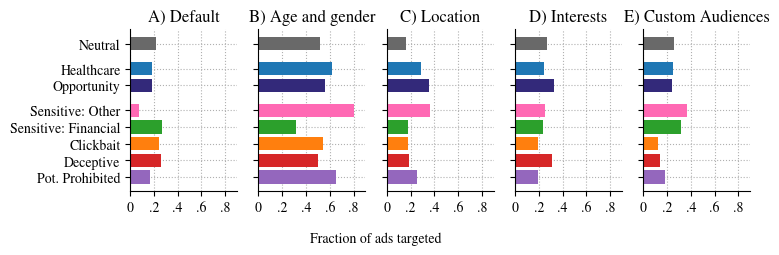

In [99]:
f, axes = plt.subplots(1, 5, sharey = True, sharex = True)

for targeting, ax in zip(['A) Default', 'B) Age and gender', 'C) Location', 'D) Interests', 'E) Custom Audiences'], axes):
    for idx, category in enumerate(categories[::-1]):
        y = idx-offsets[idx]
        ax.barh(y, usage_fractions[targeting.split(') ')[1]][category], color=colors[category])
        
    ax.set_xticks([0, .2, .4, .6, .8])
    ax.set_xticklabels(['0', '.2', '.4', '.6', '.8',])
    ax.set_xlim(0, .9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(ls=':')
    ax.set_axisbelow(True)
    ax.set_title(targeting)
    

axes[0].set_yticks(np.arange(0, len(categories)) - offsets)
axes[0].set_yticklabels([new_categogories[c] for c in categories[::-1]])


axes[1].set_xlabel('Fraction of ads targeted', loc='center')   
axes[1].xaxis.set_label_coords(1.1, -.25)
f.set_size_inches(8, 2.1)
f.savefig('rq3_prevalence.pdf', bbox_inches='tight')

In [181]:
#demographics = ['age_min_explicit', 'age_max_explicit', 'gender', 'location']

usage_fractions = defaultdict(lambda: defaultdict(float))

total_total = 0

#demographics = ['age_min_explicit', 'age_max_explicit', 'gender', 'location']


for cat in categories:
    total = ~combined[cat].isna()
    total_total += total.sum()
    
    # demographics
    dem_use =  total & ((combined['age_min_explicit']!=6) |\
                    (combined['age_max_explicit']!=54) |\
                    (~combined['gender'].isna()))
    usage_fractions['Age and gender'][cat] = dem_use.sum()/total.sum()
    usage_fractions['Age and gender']['all'] += dem_use.sum()
    
    # age and gender separate
    gender_use = total & ((~combined['gender'].isna()))
    age_use = total & ((combined['age_min_explicit']!=6) |\
                    (combined['age_max_explicit']!=54))
    usage_fractions['Age']['all'] += age_use.sum()
    usage_fractions['Gender']['all'] += gender_use.sum()
    
    
    # location
    usage_fractions['Location'][cat] = (total & (~combined['location'].isna())).sum()/total.sum()
    usage_fractions['Location']['all'] += (total & (~combined['location'].isna())).sum()
    
    
    # interests
    interest_use = total & (~combined['WAISTUIInterestsType'].isna())
    usage_fractions['Interests'][cat] = interest_use.sum()/total.sum()
    usage_fractions['Interests']['all'] += interest_use.sum()
    
    
    
    # custom
    custom_use = total & (~combined['WAISTUICustomAudienceType'].isna())
    usage_fractions['Custom Audiences'][cat] = custom_use.sum()/total.sum()
    usage_fractions['Custom Audiences']['all'] += custom_use.sum()
    
    
    # default
    default_use = total & (combined['age_min_explicit']==6)\
                & (combined['age_max_explicit']==54)\
                & ((combined['WAISTUILocaleType'].isin(["{'locales': [24, 6]}","{'locales': [6]}"])) \
                       | combined['WAISTUILocaleType'].isna())
    for param in ['WAISTUIInterestsType', 'WAISTUILocaleType', 'WAISTUICustomAudienceType',
                 'WAISTUIBCTType', 'WAISTUIEduStatusType', 'WAISTUIDPAType',
           'WAISTUIActionableInsightsType', 'WAISTUIFriendsOfConnectionType',
           'WAISTUIRelationshipType', 'WAISTUIWorkEmployerType',
           'WAISTUILocalReachType', 'WAISTUIEduSchoolsType',
           'WAISTUIConnectionType', 'WAISTUICollaborativeAdsStoreVisitsType',
           'WAISTUIJobTitleType']:
        default_use = default_use & combined[param].isna()
    usage_fractions['Default'][cat] = default_use.sum()/total.sum()
    usage_fractions['Default']['all'] += default_use.sum()
                
    

                
    

    

In [213]:
combined.shape

(27502, 31)

In [217]:
default_use.sum()

114

In [216]:
# FOR ABSTRACT: how many problematic ads were default targeted?

total_problematic = 0
problematic_default = 0
for cat in ['Sensitive', 'Financial', 'Clickbait', 'Potentially Prohibited', 'Potentially Harmful']:
    total = ~combined[cat].isna()
    total_problematic += total.sum()
    
    default_use = total & (combined['age_min_explicit']==6)\
                & (combined['age_max_explicit']==54)\
                & ((combined['WAISTUILocaleType'].isin(["{'locales': [24, 6]}","{'locales': [6]}"])) \
                       | combined['WAISTUILocaleType'].isna())
    for param in ['WAISTUIInterestsType', 'WAISTUILocaleType', 'WAISTUICustomAudienceType',
                 'WAISTUIBCTType', 'WAISTUIEduStatusType', 'WAISTUIDPAType',
           'WAISTUIActionableInsightsType', 'WAISTUIFriendsOfConnectionType',
           'WAISTUIRelationshipType', 'WAISTUIWorkEmployerType',
           'WAISTUILocalReachType', 'WAISTUIEduSchoolsType',
           'WAISTUIConnectionType', 'WAISTUICollaborativeAdsStoreVisitsType',
           'WAISTUIJobTitleType']:
        default_use = default_use & combined[param].isna()
    
    problematic_default += default_use.sum()
    
print(total_problematic, problematic_default, problematic_default/total_problematic)

3336 734 0.22002398081534771


In [182]:
print('total_total:', total_total)
for k in usage_fractions:
    print(k, usage_fractions[k]['all'], usage_fractions[k]['all']/total_total)

total_total: 27502
Age and gender 14560.0 0.5294160424696386
Age 13667.0 0.4969456766780598
Gender 3328.0 0.12100938113591739
Location 5395.0 0.19616755145080358
Interests 7388.0 0.2686350083630281
Custom Audiences 7053.0 0.2564540760671951
Default 5841.0 0.21238455385062904


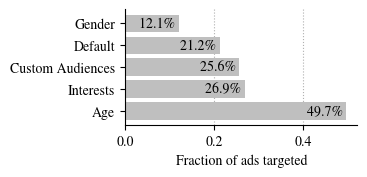

In [189]:
f, ax = plt.subplots()
# criteria = ['Default', 'Age and gender', 'Location', 'Interests', 'Custom Audiences'][::-1]
criteria = ['Gender', 'Default', 'Custom Audiences', 'Interests', 'Age'][::-1]
for idx, targeting in enumerate(criteria):
    value = usage_fractions[targeting]['all']/total_total
    ax.barh(idx, value, color=(.75, .75, .75))
    ax.annotate(xy = (value, idx), xycoords='data', 
                text=f'{(value*100):.1f}% ', ha='right', va='center')
ax.set_xlabel('Fraction of ads targeted')
ax.set_yticks(range(0, len(criteria)))
ax.set_yticklabels(criteria)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid(ls=':')
ax.set_axisbelow(True)
f.set_size_inches(3, 1.5)
f.savefig('rq3_prevalence.pdf', bbox_inches='tight')


# KW tests for medians
In the paper we say: Notably, Clickbait, Deceiptive, and Sensitive: Financial ads target audiences that are at least as large as the audiences targeted by Neutral ads.
We need to verify using the kruskal wallis test for medians.

In [197]:
from scipy.stats import kruskal

for category in ['Clickbait', 'Potentially Harmful', 'Financial']:
    print(category)
    a = combined.loc[(combined[category]==1), 'estimate_mau'].dropna()
    b = combined.loc[(combined['Benign']==1), 'estimate_mau'].dropna()
    print(a.median() - b.median())
    print(kruskal(combined.loc[(combined[category]==1), 'estimate_mau'].dropna(),
            combined.loc[(combined['Benign']==1), 'estimate_mau'].dropna()))

Clickbait
49400000.0
KruskalResult(statistic=10.983623004652882, pvalue=0.0009192055445101283)
Potentially Harmful
-100000.0
KruskalResult(statistic=0.3068772329162744, pvalue=0.5796027918678412)
Financial
28600000.0
KruskalResult(statistic=10.981207720530392, pvalue=0.0009204042933410191)


On the other hand, advertisers of Opportunity, Healthcare, Potentially Prohibited and Sensitive: Other make more active use of the available targeting criteria to more precisely specify the audiences they want to reach.

In [198]:
for category in ['Opportunity', 'Healthcare', 'Potentially Prohibited', 'Sensitive']:
    print(category)
    a = combined.loc[(combined[category]==1), 'estimate_mau'].dropna()
    b = combined.loc[(combined['Benign']==1), 'estimate_mau'].dropna()
    print(a.median() - b.median())
    print(kruskal(combined.loc[(combined[category]==1), 'estimate_mau'].dropna(),
            combined.loc[(combined['Benign']==1), 'estimate_mau'].dropna()))

Opportunity
-82150000.0
KruskalResult(statistic=254.19326796585796, pvalue=3.1644569897809074e-57)
Healthcare
-37400000.0
KruskalResult(statistic=113.72265775804581, pvalue=1.498707311265766e-26)
Potentially Prohibited
-35700000.0
KruskalResult(statistic=7.622943458628541, pvalue=0.005763034956770196)
Sensitive
-67950000.0
KruskalResult(statistic=70.08620207106252, pvalue=5.676866700075538e-17)
